STEP 1 — Identify Missing Values (NaN + zeros-as-missing)

Shape: (768, 9)
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

NaN counts in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero counts (potentially missing) in key clinical columns:
Insulin          374
SkinThickness    227
BloodPressure     35
BMI               11
Glucose            5
dtype: int64

Zero percentages (%):
Glucose           0.7
BloodPressure     4.6
SkinThickness    29.6
Insulin          48.7
BMI               1.4
dtype: float64


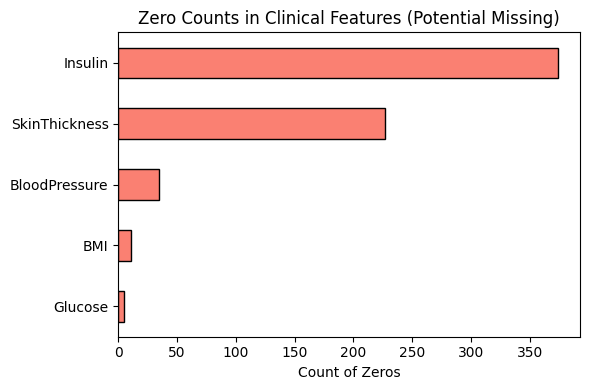

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0


In [5]:
# --- Step 1: Identify Missing Values ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load data (upload diabetes.csv to Colab first)
df = pd.read_csv('/content/diabetes.csv')

# 2) Quick shape + dtypes
print("Shape:", df.shape)
print(df.dtypes)

# 3) True NaNs
print("\nNaN counts in each column:")
print(df.isna().sum())

# 4) Zeros-as-missing: columns where '0' is physiologically unlikely
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

zero_counts = (df[zero_cols] == 0).sum().sort_values(ascending=False)
zero_perc = ((df[zero_cols] == 0).sum() / len(df) * 100).round(1)

print("\nZero counts (potentially missing) in key clinical columns:")
print(zero_counts)
print("\nZero percentages (%):")
print(zero_perc)

# 5) Bar chart of zero counts (good figure for your report)
plt.figure(figsize=(6,4))
zero_counts.sort_values().plot(kind='barh', color='salmon', edgecolor='black')
plt.title('Zero Counts in Clinical Features (Potential Missing)')
plt.xlabel('Count of Zeros')
plt.tight_layout()
plt.savefig('zero_counts.png', dpi=300, bbox_inches='tight')  # image for your report
plt.show()

# (Optional) Peek a few rows that contain any zero in these columns
mask_any_zero = (df[zero_cols] == 0).any(axis=1)
df[mask_any_zero].head()


STEP 2 — Handling Missing Values

In [6]:

# Columns where zero = missing
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Replace 0 with median of non-zero values for each column
for col in zero_cols:
    median_val = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median_val)

# Check again after imputation
print("Zero counts after imputation:\n")
print((df[zero_cols] == 0).sum())


Zero counts after imputation:

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


Step 3 — Categorical Encoding

check  dataset has any categorical (non-numeric) variables

In [7]:
# Check data types
print(df.dtypes)


cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", list(cat_cols))


Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
Categorical columns: []


 Step 4: Scaling / Normalization.

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.866045      -0.031990       0.670643 -0.181541  0.166619   
1    -0.844885 -1.205066      -0.528319      -0.012301 -0.181541 -0.852200   
2     1.233880  2.016662      -0.693761      -0.012301 -0.181541 -1.332500   
3    -0.844885 -1.073567      -0.528319      -0.695245 -0.540642 -0.633881   
4    -1.141852  0.504422      -2.679076       0.670643  0.316566  1.549303   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


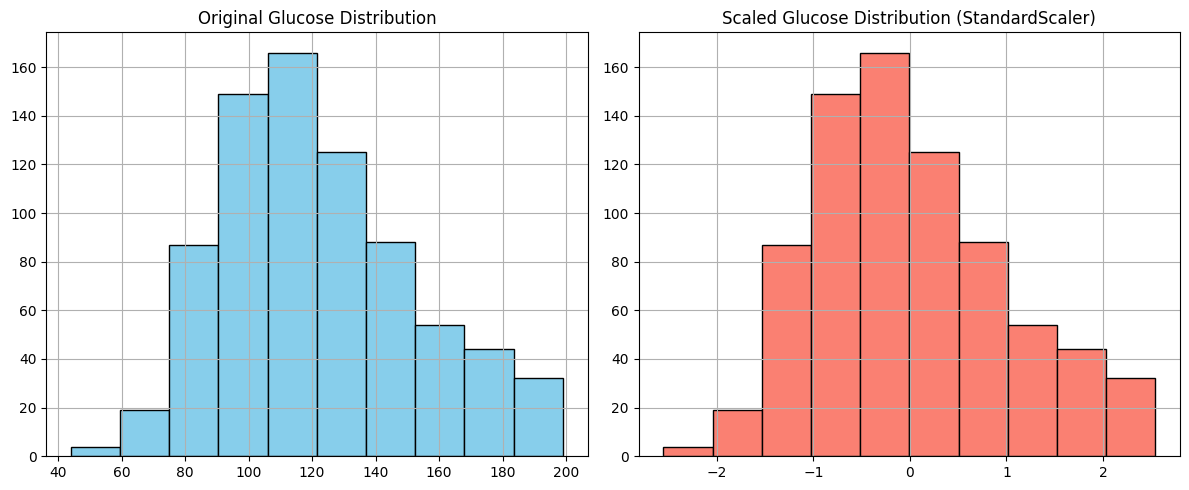

In [8]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


df_scaled = df.copy()

# Features to scale (exclude Outcome, since it's target)
features_to_scale = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                     'Insulin','BMI','DiabetesPedigreeFunction','Age']

scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Quick check
print(df_scaled.head())

# Compare original vs scaled distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original Glucose
df['Glucose'].hist(ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Original Glucose Distribution')

# Scaled Glucose
df_scaled['Glucose'].hist(ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Scaled Glucose Distribution (StandardScaler)')

plt.tight_layout()
plt.savefig('scaling_comparison.png', dpi=300, bbox_inches='tight')  # for report
plt.show()


Step 1 — Filter Method (Correlation with Outcome)

Correlation with Outcome (r):

Glucose                     0.493
BMI                         0.312
Age                         0.238
Pregnancies                 0.222
SkinThickness               0.215
Insulin                     0.204
DiabetesPedigreeFunction    0.174
BloodPressure               0.166
Name: Outcome, dtype: float64


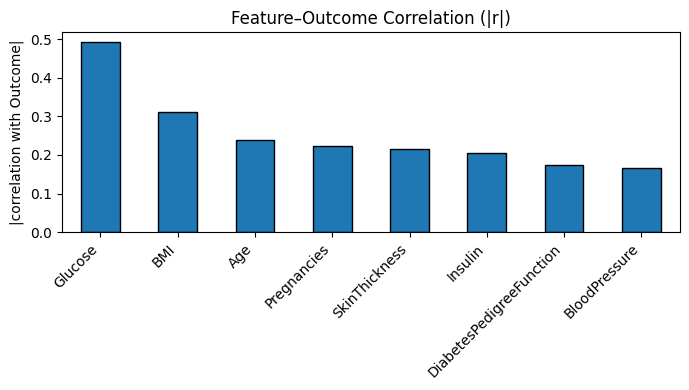

,feature,r_with_outcome,|r|
0,Glucose,0.493,0.493
1,BMI,0.312,0.312
2,Age,0.238,0.238
3,Pregnancies,0.222,0.222
4,SkinThickness,0.215,0.215
5,Insulin,0.204,0.204
6,DiabetesPedigreeFunction,0.174,0.174
7,BloodPressure,0.166,0.166


In [9]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  df_scaled has all features scaled; correlation is unaffected by linear scaling.
# Compute correlation of each feature with Outcome
corr_series = df_scaled.corr()['Outcome'].drop('Outcome')

# Sort by absolute correlation (strongest first)
corr_sorted = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

print("Correlation with Outcome (r):\n")
print(corr_sorted.round(3))

# Bar chart of |correlation|
plt.figure(figsize=(7,4))
(corr_sorted.abs()).plot(kind='bar', edgecolor='black')
plt.title('Feature–Outcome Correlation (|r|)')
plt.ylabel('|correlation with Outcome|')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('corr_with_outcome_bar.png', dpi=300, bbox_inches='tight')
plt.show()


corr_table = pd.DataFrame({
    'feature': corr_sorted.index,
    'r_with_outcome': corr_sorted.values,
    '|r|': corr_sorted.abs().values
}).round(3)
corr_table


Step 2 — Univariate Feature Selection (ANOVA F-test)

ANOVA F-test Results:
                    feature  F_score  p_value
1                   Glucose  245.668      0.0
5                       BMI   82.629      0.0
7                       Age   46.141      0.0
0               Pregnancies   39.670      0.0
3             SkinThickness   37.079      0.0
4                   Insulin   33.191      0.0
6  DiabetesPedigreeFunction   23.871      0.0
2             BloodPressure   21.632      0.0


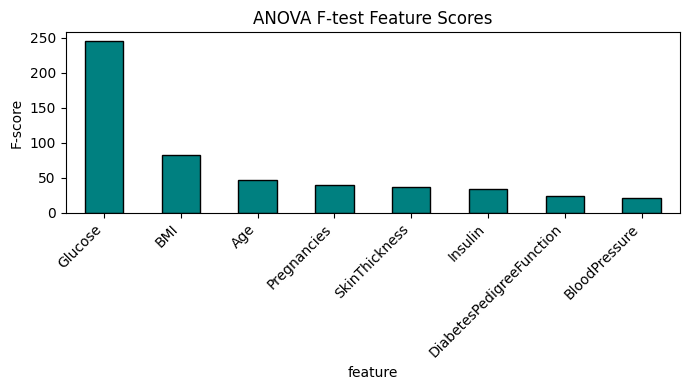

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Split into features (X) and target (y)
X = df_scaled.drop('Outcome', axis=1)   # all columns except Outcome
y = df_scaled['Outcome']                # only the Outcome column


selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)


anova_results = pd.DataFrame({
    'feature': X.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values(by='F_score', ascending=False).round(3)

print("ANOVA F-test Results:")
print(anova_results)

# Bar chart of F-scores
plt.figure(figsize=(7,4))
anova_results.set_index('feature')['F_score'].plot(kind='bar', color='teal', edgecolor='black')
plt.title('ANOVA F-test Feature Scores')
plt.ylabel('F-score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('anova_f_scores.png', dpi=300, bbox_inches='tight')  # save for report
plt.show()


Step 3 — Embedded Method (Random Forest Feature Importance)

Random Forest Feature Importances:
                    feature  importance
1                   Glucose       0.256
5                       BMI       0.166
7                       Age       0.132
6  DiabetesPedigreeFunction       0.124
4                   Insulin       0.087
2             BloodPressure       0.084
0               Pregnancies       0.079
3             SkinThickness       0.072


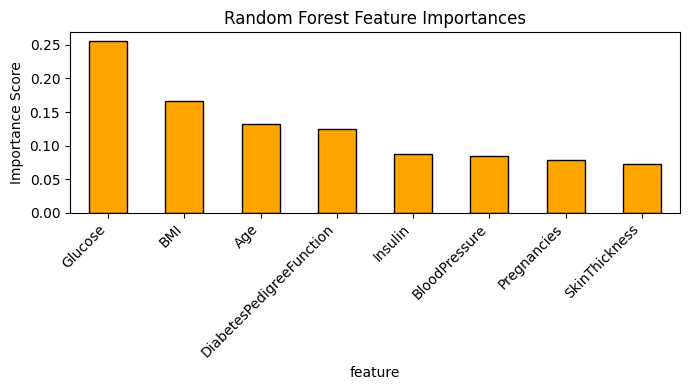

In [12]:

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt


rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

rf_results = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).round(3)

print("Random Forest Feature Importances:")
print(rf_results)

# Bar chart
plt.figure(figsize=(7,4))
rf_results.set_index('feature')['importance'].plot(kind='bar', color='orange', edgecolor='black')
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rf_importances.png', dpi=300, bbox_inches='tight')
plt.show()


Step 4 — Impact on Model (Before vs After Feature Selection)

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

def evaluate_model(X, y, features_name="All features"):
    print(f"\n===== {features_name} =====")

    # 1. Mean accuracy with cross_val_score
    scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
    print("Cross-val Accuracy (per fold):", scores.round(3))
    print("Mean Accuracy:", scores.mean().round(3))

    # 2. Detailed metrics with cross_val_predict
    y_pred = cross_val_predict(log_reg, X, y, cv=5)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("\nDetailed Metrics (using CV predictions):")
    print(" Accuracy :", round(acc,3))
    print(" Precision:", round(prec,3))
    print(" Recall   :", round(rec,3))
    print(" F1-score :", round(f1,3))
    print("\nClassification Report:\n", classification_report(y, y_pred))

# 1. All features
evaluate_model(X, y, "All features")

# 2. Selected features
X_selected = X[['Glucose','BMI','Age','Pregnancies']]
evaluate_model(X_selected, y, "Selected features")



===== All features =====
Cross-val Accuracy (per fold): [0.76  0.74  0.786 0.797 0.771]
Mean Accuracy: 0.771

Detailed Metrics (using CV predictions):
 Accuracy : 0.771
 Precision: 0.719
 Recall   : 0.563
 F1-score : 0.632

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.72      0.56      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.77      0.77      0.76       768


===== Selected features =====
Cross-val Accuracy (per fold): [0.76  0.74  0.779 0.791 0.778]
Mean Accuracy: 0.77

Detailed Metrics (using CV predictions):
 Accuracy : 0.77
 Precision: 0.714
 Recall   : 0.567
 F1-score : 0.632

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.71      0.57      0.63       268

    accu